![](london_nyc.jpg)
       

#  Capstone Project - The Battle of Neighborhoods (Week 2)

##  Introduction
New York City comprises 5 boroughs sitting where the Hudson River meets the Atlantic Ocean. At its core is Manhattan, a densely populated borough that’s among the world’s major commercial, financial and cultural centers. Its iconic sites include skyscrapers such as the Empire State Building and sprawling Central Park. Broadway theater is staged in neon-lit Times Square.

London, the capital of England and the United Kingdom, is a 21st-century city with history stretching back to Roman times. At its centre stand the imposing Houses of Parliament, the iconic ‘Big Ben’ clock tower and Westminster Abbey, site of British monarch coronations. Across the Thames River, the London Eye observation wheel provides panoramic views of the South Bank cultural complex, and the entire city.




##  Description of the problem
We will explored New York City and London and segmented and clustered their neighborhoods. Both cities are very diverse and are very similar. Both cities are a densely populated boroughs that’s among the world’s major commercial, financial and cultural centers. . We will to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. We will define that people like to do more in the cities, which places are often visited. Knowing this information we can think of how to use this. For exemple, open a new restaurant or supermarket, entertainment center or gift shop. As we can see in the next task that although there are Mexican restaurants in London, but they are not popular, entertainment is centrally located and almost none in areas farther from the center. We may also use this information for advertising purposes, etc





##  Description of Data.
This project will rely on public data from Wikipedia and Foursquare.

London is the capital of and largest city in England and the United Kingdom. It is administered by the City of London and 32 London boroughs.

We will get information about the areas of London   https://en.wikipedia.org/wiki/List_of_areas_of_London

I will use dataset   https://geo.nyu.edu/catalog/nyu_2451_34572   for information about boroughs of NYC



In [1]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# library to handle requests
import requests

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# install the Geocoder
!pip -q install geocoder
import geocoder

# import time
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium

import folium # map rendering library

from PIL import Image # converting images into arrays

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS

print ('...Done')



Matplotlib version:  2.2.3
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

...Done


### London

In [2]:
# download data and parse it:
r = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})


In [3]:
#get headers:
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")
#headers

In [4]:
#Find all items and skip first one:
rows=table.findAll('tr')
rows=rows[1:len(rows)]
#rows

In [5]:
# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")
#rows

In [6]:
# make dataframe, expand rows and drop the old one:
df=pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 7, expand = True) 
df.drop(columns=[0],inplace=True)#

df.rename(columns={'Location': 'neighborhoods', 'London\xa0borough': 'borough', 'Post town': 'posttown', 'Postcode\xa0district': 'postcode'}, inplace=True )
df.drop(columns={'OS grid ref'},inplace=True)
df.head(3)


,neighborhoods,borough,posttown,postcode,Dial code
0,"<a href=""/wiki/Abbey_Wood"" title=""Abbey Wood"">...","Bexley, Greenwich <sup class=""reference"" id=""...",LONDON,SE2,020
1,"<a href=""/wiki/Acton,_London"" title=""Acton, Lo...","Ealing, Hammersmith and Fulham<sup class=""refe...",LONDON,"W3, W4",020
2,"<a href=""/wiki/Addington,_London"" title=""Addin...","Croydon<sup class=""reference"" id=""cite_ref-mil...",CROYDON,CR0,020


In [7]:
df.update(df.neighborhoods.loc[lambda x: x.str.contains('title')].str.extract('title=\"([^\"]*)',expand=False))
# delete Toronto annotation from Neighbourhood:
df.update(df.neighborhoods.loc[lambda x: x.str.contains('London')].str.replace(", London",""))


In [8]:
for i in range(0, df.shape[0]-1):
    #print(df.borough.get_values()[i])
    c = df.borough.get_values()[i].split('<')[0]
    df.borough[i] = c

df = df.drop('borough', axis=1).join(df['borough'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('borough'))
df = df.drop('posttown', axis=1).join(df['posttown'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('posttown'))

df = df.drop('postcode', axis=1).join(df['postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('postcode'))



In [9]:
df.head()

,neighborhoods,Dial code,borough,posttown,postcode
0,Abbey Wood,020,Bexley,LONDON,SE2
0,Abbey Wood,020,Bexley,LONDON,SE2
0,Abbey Wood,020,Bexley,LONDON,SE2
0,Abbey Wood,020,Bexley,LONDON,SE2
0,Abbey Wood,020,Bexley,LONDON,SE2


In [10]:
df.shape

(2856, 5)

In [11]:
df.drop_duplicates(keep = False, inplace = True) 
  

In [12]:
df.head()

,neighborhoods,Dial code,borough,posttown,postcode
2,Addington,020,Croydon,CROYDON,CR0
3,Addiscombe,020,Croydon,CROYDON,CR0
5,Aldborough Hatch,020,Redbridge,ILFORD,IG2
6,Aldgate,020,City,LONDON,EC3
7,Aldwych,020,Westminster,LONDON,WC2


In [13]:
df.shape

(578, 5)

Now, only the Boroughs with London Post-town will be used for our search of location. Therefore, all the non-post-town are dropped.

In [14]:
df_london = df
df_london = df_london[df_london['posttown'].str.contains('LONDON')]

df_london.drop_duplicates(keep = False, inplace = True) 
  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
df_london.head()

,neighborhoods,Dial code,borough,posttown,postcode
6,Aldgate,020,City,LONDON,EC3
7,Aldwych,020,Westminster,LONDON,WC2
9,Anerley,020,Bromley,LONDON,SE20
10,Angel,020,Islington,LONDON,EC1
10,Angel,020,Islington,LONDON,N1


##### Geocoder dont read my whole data, and i  divide my dataset on smaller parts

In [16]:
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [17]:
# New dataframe for  postcodes started with "W"
df_w = df_london[df_london['postcode'].str.startswith(('W'))].reset_index(drop=True)

In [18]:
df_w.head()

,neighborhoods,Dial code,borough,posttown,postcode
0,Aldwych,020,Westminster,LONDON,WC2
1,Bayswater,020,Westminster,LONDON,W2
2,Bedford Park,020,Ealing,LONDON,W4
3,Bloomsbury,020,Camden,LONDON,WC1
4,Charing Cross,020,Westminster,LONDON,WC2


In [19]:
postcode = df_w['postcode'] 
postcode
coordinates = [get_latlng(postcode) for postcode in postcode.tolist()]


In [20]:
df_with_coordinates = df_w

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_with_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_w['Latitude'] = df_with_coordinates['Latitude']
df_w['Longitude'] = df_with_coordinates['Longitude']

In [21]:
df_w.head()

,neighborhoods,Dial code,borough,posttown,postcode,Latitude,Longitude
0,Aldwych,020,Westminster,LONDON,WC2,51.51651,-0.11968
1,Bayswater,020,Westminster,LONDON,W2,51.51494,-0.18048
2,Bedford Park,020,Ealing,LONDON,W4,51.48944,-0.26194
3,Bloomsbury,020,Camden,LONDON,WC1,51.52450,-0.12273
4,Charing Cross,020,Westminster,LONDON,WC2,51.51651,-0.11968


In [22]:
# # New dataframe for  postcodes started with "S"
df_s = df_london[df_london['postcode'].str.startswith(('S'))].reset_index(drop=True)

In [23]:
df_s.head()

,neighborhoods,Dial code,borough,posttown,postcode
0,Anerley,020,Bromley,LONDON,SE20
1,Balham,020,Wandsworth,LONDON,SW12
2,Bankside,020,Southwark,LONDON,SE1
3,Barnes,020,Richmond upon Thames,LONDON,SW13
4,Battersea,020,Wandsworth,LONDON,SW11


In [24]:
postcode = df_s['postcode'] 
postcode
coordinates = [get_latlng(postcode) for postcode in postcode.tolist()]


In [25]:
df_with_coordinates_s = df_s

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_with_coordinates_s = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_s['Latitude'] = df_with_coordinates_s['Latitude']
df_s['Longitude'] = df_with_coordinates_s['Longitude']

In [26]:
df_s.head()

,neighborhoods,Dial code,borough,posttown,postcode,Latitude,Longitude
0,Anerley,020,Bromley,LONDON,SE20,51.41009,-0.05683
1,Balham,020,Wandsworth,LONDON,SW12,51.44822,-0.14839
2,Bankside,020,Southwark,LONDON,SE1,51.49960,-0.09613
3,Barnes,020,Richmond upon Thames,LONDON,SW13,51.47457,-0.24212
4,Battersea,020,Wandsworth,LONDON,SW11,51.46760,-0.16290


In [27]:
# df_london_allpart = df_s and df_w
df_london_allpart = df_s.append(df_w, ignore_index=True)

In [28]:
df_london_allpart.shape

(129, 7)

In [29]:
# New dataframe for  postcodes started with "E"
df_e = df_london[df_london['postcode'].str.startswith(('E'))].reset_index(drop=True)

In [30]:
postcode = df_e['postcode'] 
postcode
coordinates = [get_latlng(postcode) for postcode in postcode.tolist()]


In [31]:
f_with_coordinates_e = df_e

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_with_coordinates_e = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_e['Latitude'] = df_with_coordinates_e['Latitude']
df_e['Longitude'] = df_with_coordinates_e['Longitude']

In [32]:
df_london_allpart = df_london_allpart.append(df_e, ignore_index=True)

In [33]:
# New dataframe for  postcodes started with "N"
df_n = df_london[df_london['postcode'].str.startswith(('N'))].reset_index(drop=True)

In [34]:
postcode = df_n['postcode'] 
postcode
coordinates = [get_latlng(postcode) for postcode in postcode.tolist()]


In [35]:
df_with_coordinates_s = df_n

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_with_coordinates_n = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_n['Latitude'] = df_with_coordinates_n['Latitude']
df_n['Longitude'] = df_with_coordinates_n['Longitude']

In [36]:
df_london_allpart = df_london_allpart.append(df_n, ignore_index=True)

In [37]:
#df_london_allpart.head(10)

In [38]:
# New dataframe for  postcodes started with "d"
df_d = df_london[df_london['postcode'].str.startswith(('D'))].reset_index(drop=True)

In [39]:
postcode = df_d['postcode'] 
postcode
coordinates = [get_latlng(postcode) for postcode in postcode.tolist()]


In [40]:
df_with_coordinates_s = df_d

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_with_coordinates_d = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_d['Latitude'] = df_with_coordinates_d['Latitude']
df_d['Longitude'] = df_with_coordinates_d['Longitude']

In [41]:
df_london_allpart = df_london_allpart.append(df_d, ignore_index=True)

In [42]:
# New dataframe for  postcodes started with "I"/ same =E18
df_i = df_london[df_london['postcode'].str.startswith(('I'))].reset_index(drop=True)

In [43]:
postcode = df_i['postcode'] 
postcode
coordinates = [get_latlng(postcode) for postcode in postcode.tolist()]


In [44]:
df_with_coordinates_s = df_i

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_with_coordinates_i = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_i['Latitude'] = df_with_coordinates_i['Latitude']
df_i['Longitude'] = df_with_coordinates_i['Longitude']

In [45]:
df_london_allpart = df_london_allpart.append(df_i, ignore_index=True)

In [46]:
df_london_allpart.head()

,neighborhoods,Dial code,borough,posttown,postcode,Latitude,Longitude
0,Anerley,020,Bromley,LONDON,SE20,51.41009,-0.05683
1,Balham,020,Wandsworth,LONDON,SW12,51.44822,-0.14839
2,Bankside,020,Southwark,LONDON,SE1,51.49960,-0.09613
3,Barnes,020,Richmond upon Thames,LONDON,SW13,51.47457,-0.24212
4,Battersea,020,Wandsworth,LONDON,SW11,51.46760,-0.16290


In [47]:
df_london_allpart['borough'].unique()

array(['Bromley', 'Wandsworth', 'Southwark', 'Richmond upon Thames',
       'Westminster', 'Lewisham', 'Greenwich', 'Lambeth',
       'Kensington and Chelsea', 'Merton', 'Bexley',
       'Hammersmith and Fulham', 'Kingston upon Thames', 'Croydon',
       'Ealing', 'Camden', 'Hounslow', 'Camden and Islington', 'City',
       'Islington', 'Tower Hamlets', 'Waltham Forest', 'Newham', 'Hackney',
       'Islington &amp; City', 'Redbridge', 'Enfield', 'Haringey',
       'Barnet', 'Brent', 'Haringey and Barnet', 'Dartford'], dtype=object)

In [48]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_london_allpart['borough'].unique()),
        df_london_allpart.shape[0]
    )
)

The dataframe has 32 boroughs and 285 neighborhoods.


Use geopy library to get the latitude and longitude values of London.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.




In [49]:
address = 'London, uk'

geolocator = Nominatim(user_agent="uk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London, uk {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London, uk 51.4893335, -0.144055084527687.


Create a map of London with borough superimposed on top.


In [50]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df_london_allpart['Latitude'], df_london_allpart['Longitude'], df_london_allpart['borough']):
    label = '{}.format(borough)'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london




###  New York

Download and Explore Dataset
Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

The link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572




In [51]:
# load the data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [52]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [53]:
neighborhoods_data = newyork_data['features']

In [54]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [55]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [56]:
# let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [57]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [58]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Use geopy library to get the latitude and longitude values of New York City.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.



In [59]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create a map of New York with neighborhoods superimposed on top.


In [60]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Methodology
###  Data Exploration


####  Create a new dataframe of the borough Kensington and Chelsea.

In [61]:
new_data = df_london_allpart[df_london_allpart['borough'] == 'Kensington and Chelsea'].reset_index(drop=True)
new_data = new_data.drop_duplicates()
new_data.head()

,neighborhoods,Dial code,borough,posttown,postcode,Latitude,Longitude
0,Brompton,020,Kensington and Chelsea,LONDON,SW3,51.49014,-0.16248
1,Chelsea,020,Kensington and Chelsea,LONDON,SW3,51.49014,-0.16248
2,Earls Court,020,Kensington and Chelsea,LONDON,SW5,51.49004,-0.18971
3,Kensington,020,Kensington and Chelsea,LONDON,SW7,51.49807,-0.17404
4,South Kensington,020,Kensington and Chelsea,LONDON,SW7,51.49807,-0.17404


In [62]:
address = 'Kensington and Chelsea, uk'
#address = 'City of London, uk'
#address = 'Islington, uk'

geolocator = Nominatim(user_agent="uk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London, uk {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London, uk 51.4989948, -0.1991229.


In [63]:
new_data.head()

,neighborhoods,Dial code,borough,posttown,postcode,Latitude,Longitude
0,Brompton,020,Kensington and Chelsea,LONDON,SW3,51.49014,-0.16248
1,Chelsea,020,Kensington and Chelsea,LONDON,SW3,51.49014,-0.16248
2,Earls Court,020,Kensington and Chelsea,LONDON,SW5,51.49004,-0.18971
3,Kensington,020,Kensington and Chelsea,LONDON,SW7,51.49807,-0.17404
4,South Kensington,020,Kensington and Chelsea,LONDON,SW7,51.49807,-0.17404


In [64]:
 #create map of North York using latitude and longitude values  #new_data['neighborhoods']
map_london_borough = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(new_data['Latitude'], new_data['Longitude'], new_data['borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_borough)  
    
map_london_borough

Use geopy library to get the latitude and longitude values borough  Manhattan.

In [65]:
address = 'Manhattan, usa'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [66]:
ny_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


 Let's visualizat Manhattan 

In [67]:
# create map of Manhattan using latitude and longitude values
map_nyc_m = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc_m)  
    
map_nyc_m

####  Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.



In [68]:
CLIENT_ID = 'B3D1FREXU3FMFKG0XFFFWLZH1UBNQKQGVTG4XWBI3N32354V' # your Foursquare ID
CLIENT_SECRET = 'UAFKLDYGA1SQEBZYO4P5DYUAS4DBRF5QA53DURWY03FTRQP3' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B3D1FREXU3FMFKG0XFFFWLZH1UBNQKQGVTG4XWBI3N32354V
CLIENT_SECRET:UAFKLDYGA1SQEBZYO4P5DYUAS4DBRF5QA53DURWY03FTRQP3


In [69]:
address = 'Manhattan, usa'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan, usa are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan, usa are 40.7900869, -73.9598295.


Get the neighborhood's latitude and longitude values.

Now, let's get the top 200 venues that are in Manhattan within a radius of 1000 meters.
First, let's create the GET request URL. Name your URL url.

In [70]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=B3D1FREXU3FMFKG0XFFFWLZH1UBNQKQGVTG4XWBI3N32354V&client_secret=UAFKLDYGA1SQEBZYO4P5DYUAS4DBRF5QA53DURWY03FTRQP3&v=20180604&ll=40.7900869,-73.9598295&radius=1000&limit=200'

Send the GET request and examine the resutls

In [71]:
results = requests.get(url).json()
#results

In [72]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [73]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,North Meadow,Park,40.792027,-73.959853
1,Central Park Tennis Center,Tennis Court,40.789313,-73.961862
2,East Meadow,Field,40.790160,-73.955498
3,Central Park - Gate Of All Saints,Park,40.791591,-73.964795
4,The Jewish Museum,Museum,40.785276,-73.957411


And how many venues were returned by Foursquare?



In [74]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


100 venues were returned by Foursquare.


Let's create a function to repeat the same process to all the neighborhoods.

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Create a new dataframe called ny_venues.

In [76]:
ny_venues = getNearbyVenues(names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [77]:
print(ny_venues.shape)


(3327, 7)


In [78]:
ny_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Let's check how many venues were returned for each neighborhood

In [79]:
ny_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,42,42,42,42,42,42
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,43,43,43,43,43,43
East Village,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

In [80]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 339 uniques categories.


### Analyze Each Neighborhood

In [81]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,

In [82]:
ny_onehot.shape

(3327, 340)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [83]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped.head(10)

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,

Let's confirm the new size

In [84]:
ny_grouped.shape

(40, 340)

Let's print each neighborhood along with the top 5 most common venues¶

In [85]:
num_top_venues = 5

for hood in ny_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.08
1    Coffee Shop  0.06
2          Hotel  0.05
3  Memorial Site  0.04
4            Gym  0.04


----Carnegie Hill----
         venue  freq
0  Coffee Shop  0.06
1  Pizza Place  0.06
2          Bar  0.04
3         Café  0.04
4          Gym  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1  Fried Chicken Joint  0.05
2   Chinese Restaurant  0.05
3                  Bar  0.05
4  American Restaurant  0.05


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1  Italian Restaurant  0.05
2      Ice Cream Shop  0.05
3           Nightclub  0.04
4              Bakery  0.04


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1           Cocktail Bar  0.05
2  Vietnamese Restaurant  0.04
3     Salon / Barbershop  0.04
4    American Restaurant  0.04


----Civic Center----
                  venue  freq
0  Gym / Fitness Center  0.05
1    Italian

Let's put that into a pandas dataframe

In [86]:
#a function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [87]:
#create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10
word_string3 = ''
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)
    word_string3 = word_string3 + neighborhoods_venues_sorted.iloc[ind, 1:] + ' '

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Gym,Memorial Site,Italian Restaurant,Wine Shop,Playground,Department Store,Cupcake Shop
1,Carnegie Hill,Pizza Place,Coffee Shop,Bar,Café,Yoga Studio,Grocery Store,Japanese Restaurant,Gym,French Restaurant,Cosmetics Shop
2,Central Harlem,African Restaurant,Public Art,Cosmetics Shop,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Fried Chicken Joint,French Restaurant,Cycle Studio
3,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,Bakery,Art Gallery,Seafood Restaurant,Theater,Hotel,American Restaurant
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Ice Cream Shop,Bubble Tea Shop,Spa,Dumpling Restaurant,Bakery


### Vizualization with word cloud

In [88]:
stopwords = set(STOPWORDS)


In [89]:
word_string4 = ''
for i in range(0, num_top_venues ):
    word_string4 = word_string4 + word_string3[i]


Word cloud created!


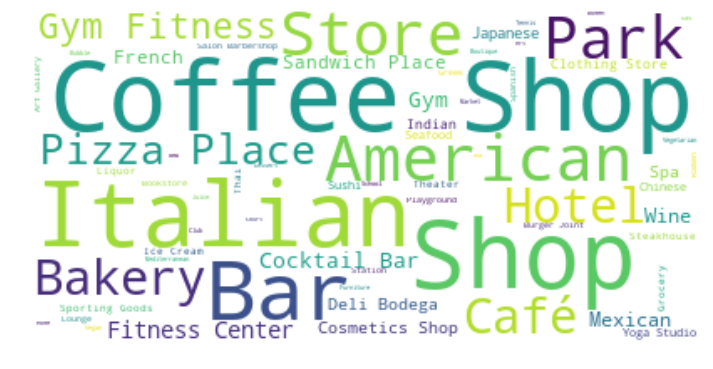

In [90]:
# create the word cloud
stopwords.add('Restaurant')
wordcloud = WordCloud(background_color='white', stopwords = stopwords).generate(word_string4)

print('Word cloud created!')

# display the cloud
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(15)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 4. Cluster Neighborhoods
Run k-means to cluster the neighborhood into 5 clusters.

In [91]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 2, 1, 2, 2, 0, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [92]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Sandwich Place,Discount Store,Coffee Shop,Yoga Studio,Spa,Steakhouse,Supplement Shop,Shopping Mall,Tennis Stadium,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Ice Cream Shop,Bubble Tea Shop,Spa,Dumpling Restaurant,Bakery
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Grocery Store,Deli / Bodega,Mobile Phone Shop,Bakery,Gym,Tapas Restaurant,Coffee Shop,Park,Clothing Store
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Café,Lounge,Deli / Bodega,Bakery,Pizza Place,Restaurant,Frozen Yogurt Shop,Spanish Restaurant,Park
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Café,Pizza Place,Coffee Shop,Yoga Studio,Park,Sandwich Place,School,Deli / Bodega,Liquor Store


Finally, let's visualize the resulting clusters



In [93]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Examining the clusters
Let's try and see each cluster and the most common venue among each.

In [94]:
# For Cluster 0
result = ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(0, result['1st Most Common Venue'].value_counts()))
result

For cluster 0, the distribution of venues is as:
Mexican Restaurant    4
Coffee Shop           1
Italian Restaurant    1
Café                  1
Name: 1st Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Grocery Store,Deli / Bodega,Mobile Phone Shop,Bakery,Gym,Tapas Restaurant,Coffee Shop,Park,Clothing Store
3,Inwood,Mexican Restaurant,Café,Lounge,Deli / Bodega,Bakery,Pizza Place,Restaurant,Frozen Yogurt Shop,Spanish Restaurant,Park
4,Hamilton Heights,Mexican Restaurant,Café,Pizza Place,Coffee Shop,Yoga Studio,Park,Sandwich Place,School,Deli / Bodega,Liquor Store
5,Manhattanville,Italian Restaurant,Park,Mexican Restaurant,Seafood Restaurant,Coffee Shop,Liquor Store,Cuban Restaurant,Bus Station,Bike Trail,Lounge
7,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Latin American Restaurant,Spa,Thai Restaurant,Café,Liquor Store,Taco Place,Gas Station
25,Manhattan Valley,Coffee Shop,Pizza Place,Indian Restaurant,Yoga Studio,Mexican Restaurant,Thai Restaurant,Deli / Bodega,Playground,Café,Bar
36,Tudor City,Mexican Restaurant,Park,Greek Restaurant,Pizza Place,Café,Deli / Bodega,Hotel,Spa,Spanish Restaurant,Garden


In [95]:
# For Cluster 1
result = ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(1, result['1st Most Common Venue'].value_counts()))
result

For cluster 1, the distribution of venues is as:
Coffee Shop             4
Italian Restaurant      3
Bar                     2
Gym / Fitness Center    1
Chinese Restaurant      1
African Restaurant      1
Sandwich Place          1
Pizza Place             1
Korean Restaurant       1
Name: 1st Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Ice Cream Shop,Bubble Tea Shop,Spa,Dumpling Restaurant,Bakery
6,Central Harlem,African Restaurant,Public Art,Cosmetics Shop,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Fried Chicken Joint,French Restaurant,Cycle Studio
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Pizza Place,Sushi Restaurant,Deli / Bodega,Wine Shop,Japanese Restaurant,Mexican Restaurant
10,Lenox Hill,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Burger Joint,Gym,Gym / Fitness Center,Cosmetics Shop,Sporting Goods Shop,Cocktail Bar
11,Roosevelt Island,Sandwich Place,Coffee Shop,Dry Cleaner,Gym / Fitness Center,Gym,Greek Restaurant,Liquor Store,School,Market,Hotel
12,Upper West Side,Italian Restaurant,Wine Bar,Bar,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Bakery,Indian Restaurant,Cosmetics Shop,Coffee Shop,Pub
16,Murray Hill,Coffee Shop,Sandwich Place,Hotel,Japanese Restaurant,French Restaurant,Bar,Gym,Gym / Fitness Center,Italian Restaurant,Bakery
19,East Village,Bar,Wine Bar,Chinese Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop,Ramen Restaurant,Cocktail Bar,Vegetarian / Vegan Restaurant
20,Lower East Side,Coffee Shop,Chinese Restaurant,Café,Ramen Restaurant,Pizza Place,Japanese Restaurant,Park,Cocktail Bar,Sandwich Place,Bakery
27,Gramercy,Bar,Italian Restaurant,American Restaurant,Pizza Place,Bagel Shop,Cocktail Bar,Mexican Restaurant,Ice Cream Shop,Thai Restaurant,Grocery Store


In [96]:
# For Cluster 2
result = ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(2, result['1st Most Common Venue'].value_counts()))
result

For cluster 2, the distribution of venues is as:
Italian Restaurant      5
Theater                 2
Park                    2
Gym / Fitness Center    1
Gym                     1
Hotel                   1
Clothing Store          1
Coffee Shop             1
American Restaurant     1
Bakery                  1
Name: 1st Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Exhibit,Art Gallery,Bakery,Coffee Shop,Gym / Fitness Center,French Restaurant,Hotel,Juice Bar,Spa
13,Lincoln Square,Theater,Gym / Fitness Center,Café,Plaza,Concert Hall,Italian Restaurant,French Restaurant,Performing Arts Venue,Park,Opera House
14,Clinton,Theater,Gym / Fitness Center,Italian Restaurant,American Restaurant,Hotel,Wine Shop,Spa,Sandwich Place,Coffee Shop,Lounge
15,Midtown,Hotel,Coffee Shop,Cocktail Bar,Clothing Store,Theater,Sporting Goods Shop,Bakery,Bookstore,Spa,Steakhouse
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,Bakery,Art Gallery,Seafood Restaurant,Theater,Hotel,American Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Clothing Store,Chinese Restaurant,Cosmetics Shop,Café,Indian Restaurant,Seafood Restaurant,French Restaurant,Burger Joint
21,Tribeca,Italian Restaurant,Spa,Park,Café,American Restaurant,Boutique,Wine Shop,Wine Bar,Gym,Greek Restaurant
22,Little Italy,Bakery,Café,Italian Restaurant,Bubble Tea Shop,Clothing Store,Cocktail Bar,Sandwich Place,Salon / Barbershop,Mediterranean Restaurant,Women's Store
23,Soho,Clothing Store,Boutique,Art Gallery,Shoe Store,Women's Store,Italian Restaurant,Men's Store,Bakery,Sporting Goods Shop,Furniture / Home Store
24,West Village,Italian Restaurant,Cosmetics Shop,New American Restaurant,Park,Jazz Club,Wine Bar,American Restaurant,Cocktail Bar,Bakery,Coffee Shop


In [97]:
# For Cluster 3
result = ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(3, result['1st Most Common Venue'].value_counts()))
result

For cluster 3, the distribution of venues is as:
Bar    1
Name: 1st Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Bar,Park,Playground,Pet Service,Gas Station,Boat or Ferry,German Restaurant,Farmers Market,Basketball Court,Baseball Field


In [98]:
#For Cluster 4
#result = ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
#print("For cluster {}, the distribution of venues is as:\n{}".format(4, result['1st Most Common Venue'].value_counts()))
#result


###  Let's explore the Kensington and Chelsea, uk in our dataframe.
Get the neighborhood's name.

In [99]:
address = 'Kensington and Chelsea, uk'

geolocator = Nominatim(user_agent="uk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kensington and Chelsea, uk {}, {}.'.format(latitude, longitude))

GeocoderTimedOut: Service timed out

In [ ]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

In [ ]:
results1 = requests.get(url).json()
#results1

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [100]:
venues = results1['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

NameError: name 'results1' is not defined

In [101]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


100 venues were returned by Foursquare.


In [102]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [103]:
uk_venues = getNearbyVenues(names=new_data['neighborhoods'],
                                   latitudes=new_data['Latitude'],
                                   longitudes=new_data['Longitude'])


Brompton
Chelsea
Earls Court
Kensington
South Kensington
West Brompton
Holland Park
North Kensington
Notting Hill


In [104]:
print(uk_venues.shape)


(900, 7)


In [105]:
uk_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Brompton,51.49014,-0.16248,Venchi,51.489239,-0.164265,Ice Cream Shop
1,Brompton,51.49014,-0.16248,Saturday Farmers' Market,51.490917,-0.160329,Farmers Market
2,Brompton,51.49014,-0.16248,Duke of York Square,51.491272,-0.159827,Plaza
3,Brompton,51.49014,-0.16248,The Five Fields,51.491770,-0.161191,Restaurant
4,Brompton,51.49014,-0.16248,Amorino,51.489455,-0.163803,Ice Cream Shop


In [106]:
uk_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Brompton,100,100,100,100,100,100
Chelsea,100,100,100,100,100,100
Earls Court,100,100,100,100,100,100
Holland Park,100,100,100,100,100,100
Kensington,100,100,100,100,100,100
North Kensington,100,100,100,100,100,100
Notting Hill,100,100,100,100,100,100
South Kensington,100,100,100,100,100,100
West Brompton,100,100,100,100,100,100


In [107]:
print('There are {} uniques categories.'.format(len(uk_venues['Venue Category'].unique())))

There are 135 uniques categories.


In [108]:
# one hot encoding
uk_onehot = pd.get_dummies(uk_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uk_onehot['Neighborhood'] = uk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [uk_onehot.columns[-1]] + list(uk_onehot.columns[:-1])
uk_onehot = uk_onehot[fixed_columns]

uk_onehot.head()

,Neighborhood,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Burger Joint,Butcher,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Donut Shop,English Restaurant,Ethiopian Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fountain,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Latin American Restaurant,Lebanese Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Opera House,Palace,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Climbing Spot,Russian Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shopping Plaza,Skate Park,Soccer Stadium,Social Club,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Turkish Restaurant,University,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Brompton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Brompton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Brompton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Brompton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Brompton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
uk_onehot.shape

(900, 136)

In [110]:
uk_grouped = uk_onehot.groupby('Neighborhood').mean().reset_index()
uk_grouped

,Neighborhood,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Burger Joint,Butcher,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Donut Shop,English Restaurant,Ethiopian Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fountain,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Latin American Restaurant,Lebanese Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Opera House,Palace,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Climbing Spot,Russian Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shopping Plaza,Skate Park,Soccer Stadium,Social Club,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Turkish Restaurant,University,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Brompton,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.00,0.05,0.00,0.02,0.03,0.01,0.01,0.01,0.00,0.07,0.00,0.01,0.00,0.01,0.01,0.03,0.02,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.05,0.00,0.02,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.02,0.01,0.00,0.00,0.00,0.03,0.04,0.01,0.00,0.00,0.03,0.03,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00
1,Chelsea,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.00,0.05,0.00,0.02,0.03,0.01,0.01,0.01,0.00,0.07,0.00,0.01,0.00,0.01,0.01,0.03,0.02,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.05,0.00,0.02,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.02,0.01,0.00,0.00,0.00,0.03,0.04,0.01,0.00,0.00,0.03,0.03,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00
2,Earls Court,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.03,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.04,0.00,0.00,0.01,0.00,0.08,0.02,0.02,0.01,0.01,0.05,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.05,0.00,0.00,0.00,0.01,0.04,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.01,0.02,0.01,0.00,0.00,0.02,0.01,0.01,0.01,0.00,0.01,0.00,0.02,0.01,0.02,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0

In [111]:
num_top_venues = 5

for hood in uk_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = uk_grouped[uk_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Brompton----
               venue  freq
0               Café  0.07
1  French Restaurant  0.05
2             Bakery  0.05
3     Ice Cream Shop  0.04
4              Hotel  0.03


----Chelsea----
               venue  freq
0               Café  0.07
1  French Restaurant  0.05
2             Bakery  0.05
3     Ice Cream Shop  0.04
4              Hotel  0.03


----Earls Court----
                  venue  freq
0                 Hotel  0.08
1    Italian Restaurant  0.05
2           Pizza Place  0.05
3  Gym / Fitness Center  0.04
4                   Pub  0.04


----Holland Park----
                venue  freq
0                 Pub  0.07
1              Bakery  0.04
2  Italian Restaurant  0.04
3               Hotel  0.04
4          Restaurant  0.04


----Kensington----
                 venue  freq
0   Italian Restaurant  0.08
1                 Café  0.07
2                Hotel  0.06
3       Science Museum  0.04
4  Japanese Restaurant  0.03


----North Kensington----
                  venue  f

In [112]:
#a function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [113]:
#create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10
word_string1 = ''
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_uk = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_uk['Neighborhood'] = uk_grouped['Neighborhood']

for ind in np.arange(uk_grouped.shape[0]):
    neighborhoods_venues_sorted_uk.iloc[ind, 1:] = return_most_common_venues(uk_grouped.iloc[ind, :], num_top_venues)
    word_string1 = word_string1 + neighborhoods_venues_sorted_uk.iloc[ind, 1:] + ' '

neighborhoods_venues_sorted_uk,head()

(       Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
 0          Brompton                  Café                Bakery   
 1           Chelsea                  Café                Bakery   
 2       Earls Court                 Hotel           Pizza Place   
 3      Holland Park                   Pub                Bakery   
 4        Kensington    Italian Restaurant                  Café   
 5  North Kensington                   Pub  Gym / Fitness Center   
 6      Notting Hill                   Pub    Italian Restaurant   
 7  South Kensington    Italian Restaurant                  Café   
 8     West Brompton    Italian Restaurant                  Café   
 
   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
 0     French Restaurant        Ice Cream Shop   Japanese Restaurant   
 1     French Restaurant        Ice Cream Shop   Japanese Restaurant   
 2    Italian Restaurant                   Pub  Gym / Fitness Center   
 3                 Hotel      

In [114]:
#word_string1[0]

In [115]:
word_string2 = ''
for i in range(0, num_top_venues ):
    word_string2 = word_string2 + word_string1[i]
#print (word_string2) 

Word cloud created!


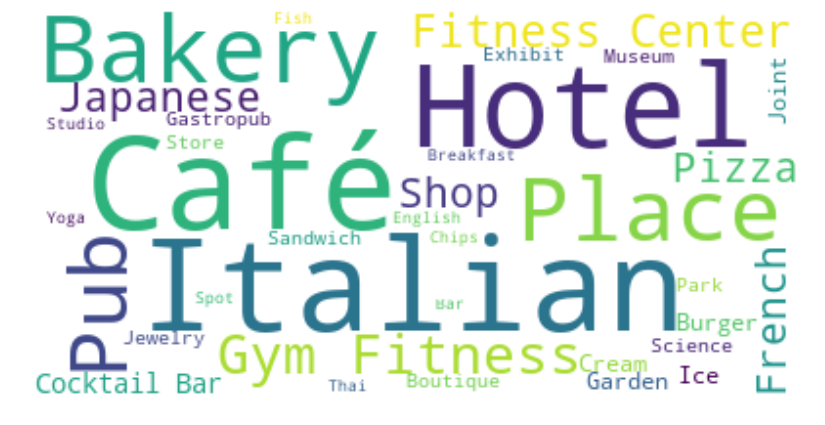

In [116]:
# display the generated text
stopwords.add('Restaurant')
#word_string

# create the word cloud
wordcloud = WordCloud(background_color='white',stopwords = stopwords).generate(word_string2)

print('Word cloud created!')

# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [117]:
# set number of clusters
kclusters = 4

uk_grouped_clustering = uk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(uk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 3, 3, 1, 0, 0, 1, 3], dtype=int32)

In [118]:
uk_merged = new_data
# add clustering labels
uk_merged['Cluster Labels'] = kmeans.labels_

uk_merged = uk_merged.join(neighborhoods_venues_sorted_uk.set_index('Neighborhood'), on='neighborhoods')

uk_merged.head() # check the last columns!

,neighborhoods,Dial code,borough,posttown,postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brompton,020,Kensington and Chelsea,LONDON,SW3,51.49014,-0.16248,2,Café,Bakery,French Restaurant,Ice Cream Shop,Japanese Restaurant,Cocktail Bar,Italian Restaurant,Hotel,Boutique,Gastropub
1,Chelsea,020,Kensington and Chelsea,LONDON,SW3,51.49014,-0.16248,2,Café,Bakery,French Restaurant,Ice Cream Shop,Japanese Restaurant,Cocktail Bar,Italian Restaurant,Hotel,Boutique,Gastropub
2,Earls Court,020,Kensington and Chelsea,LONDON,SW5,51.49004,-0.18971,3,Hotel,Pizza Place,Italian Restaurant,Pub,Gym / Fitness Center,Thai Restaurant,Bakery,Café,French Restaurant,Ice Cream Shop
3,Kensington,020,Kensington and Chelsea,LONDON,SW7,51.49807,-0.17404,3,Italian Restaurant,Café,Hotel,Science Museum,Japanese Restaurant,Burger Joint,Garden,Exhibit,Sandwich Place,Jewelry Store
4,South Kensington,020,Kensington and Chelsea,LONDON,SW7,51.49807,-0.17404,1,Italian Restaurant,Café,Hotel,Science Museum,Japanese Restaurant,Burger Joint,Garden,Exhibit,Sandwich Place,Jewelry Store


In [119]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(uk_merged['Latitude'], uk_merged['Longitude'], uk_merged['neighborhoods'], uk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [120]:
# For Cluster 0
result = uk_merged.loc[uk_merged['Cluster Labels'] == 0, uk_merged.columns[[1] + list(range(5, uk_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(0, result['1st Most Common Venue'].value_counts()))
result



For cluster 0, the distribution of venues is as:
Italian Restaurant    1
Pub                   1
Name: 1st Most Common Venue, dtype: int64


,Dial code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,020,51.48563,-0.18144,0,Italian Restaurant,Café,Bakery,Pub,Hotel,Restaurant,Pizza Place,French Restaurant,Yoga Studio,Gym / Fitness Center
6,020,51.50162,-0.19173,0,Pub,Bakery,Hotel,Café,Italian Restaurant,Restaurant,English Restaurant,Gym / Fitness Center,Burger Joint,Garden


In [121]:
# For Cluster 1
result = uk_merged.loc[uk_merged['Cluster Labels'] == 1, uk_merged.columns[[1] + list(range(5, uk_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(1, result['1st Most Common Venue'].value_counts()))
result


For cluster 1, the distribution of venues is as:
Italian Restaurant    1
Pub                   1
Name: 1st Most Common Venue, dtype: int64


,Dial code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,020,51.49807,-0.17404,1,Italian Restaurant,Café,Hotel,Science Museum,Japanese Restaurant,Burger Joint,Garden,Exhibit,Sandwich Place,Jewelry Store
7,020,51.52346,-0.21353,1,Pub,Gym / Fitness Center,Italian Restaurant,Bakery,Pizza Place,Café,Cocktail Bar,Bar,Park,Restaurant


In [122]:
# For Cluster 2
result = uk_merged.loc[uk_merged['Cluster Labels'] == 2, uk_merged.columns[[1] + list(range(5, uk_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(2, result['1st Most Common Venue'].value_counts()))
result


For cluster 2, the distribution of venues is as:
Café    2
Name: 1st Most Common Venue, dtype: int64


,Dial code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,020,51.49014,-0.16248,2,Café,Bakery,French Restaurant,Ice Cream Shop,Japanese Restaurant,Cocktail Bar,Italian Restaurant,Hotel,Boutique,Gastropub
1,020,51.49014,-0.16248,2,Café,Bakery,French Restaurant,Ice Cream Shop,Japanese Restaurant,Cocktail Bar,Italian Restaurant,Hotel,Boutique,Gastropub


In [123]:
# For Cluster 3
result = uk_merged.loc[uk_merged['Cluster Labels'] == 3, uk_merged.columns[[1] + list(range(5, uk_merged.shape[1]))]]
print("For cluster {}, the distribution of venues is as:\n{}".format(3, result['1st Most Common Venue'].value_counts()))
result


For cluster 3, the distribution of venues is as:
Hotel                 1
Italian Restaurant    1
Pub                   1
Name: 1st Most Common Venue, dtype: int64


,Dial code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,020,51.49004,-0.18971,3,Hotel,Pizza Place,Italian Restaurant,Pub,Gym / Fitness Center,Thai Restaurant,Bakery,Café,French Restaurant,Ice Cream Shop
3,020,51.49807,-0.17404,3,Italian Restaurant,Café,Hotel,Science Museum,Japanese Restaurant,Burger Joint,Garden,Exhibit,Sandwich Place,Jewelry Store
8,020,51.51244,-0.20639,3,Pub,Italian Restaurant,Gym / Fitness Center,Bakery,Park,Café,Breakfast Spot,Cocktail Bar,Pizza Place,Fish & Chips Shop


#### Entertainment in NYC

In [124]:
#address = '102 North End Ave, New York, NY'
address = '575 5th Ave, New York'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7563907 -73.9782057


In [125]:
#let's define a query to search for entertainment that is within 2000 metres in nyc.
search_query = 'Escape Games'
radius = 2000
print(search_query + ' .... OK!')

# Define the corresponding URL
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url


Escape Games .... OK!


'https://api.foursquare.com/v2/venues/search?client_id=B3D1FREXU3FMFKG0XFFFWLZH1UBNQKQGVTG4XWBI3N32354V&client_secret=UAFKLDYGA1SQEBZYO4P5DYUAS4DBRF5QA53DURWY03FTRQP3&ll=40.7563907,-73.9782057&v=20180604&query=Escape Games&radius=2000&limit=200'

In [126]:
#  Send the GET Request and examine the results
results = requests.get(url).json()
#results

In [127]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",False,5bf0c411364d970034315383,265 W 37th St,US,New York,United States,NaN,1172,"[265 W 37th St, New York, NY 10018, United Sta...","[{'label': 'display', 'lat': 40.754016, 'lng':...",40.754016,-73.991748,NaN,10018,NY,Mission Escape Games,v-1564760451,NaN
1,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",False,56abc458498ee6c0b6ad7f0a,"435 5th Avenue, 4th Floor",US,New York,United States,NaN,656,"[435 5th Avenue, 4th Floor, New York, NY 10016...","[{'label': 'display', 'lat': 40.75139156486494...",40.751392,-73.982329,Garment District,10016,NY,Riddle Me Out Escape Games NYC,v-1564760451,152966516
2,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",False,4bc93a3b3740b713cc825e65,101 W 55th St,US,New York,United States,"6th Ave, NW corner",767,"[101 W 55th St (6th Ave, NW corner), New York,...","[{'label': 'display', 'lat': 40.76327188497643...",40.763272,-73.978747,NaN,10019,NY,Escape Day Spa & Skin Care,v-1564760451,NaN
3,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",False,4b9685d3f964a520fad134e3,1285 Avenue of the Americas,US,New York,United States,W 51st St,318,"[1285 Avenue of the Americas (W 51st St), New ...","[{'label': 'display', 'lat': 40.75864, 'lng': ...",40.758640,-73.980547,NaN,10019,NY,BBDO NY - Escape Hatch,v-1564760451,NaN
4,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",False,59c4073de1f2282d14b2cc69,246 W 38th St Fl 7,US,New York,United States,NaN,1058,"[246 W 38th St Fl 7, New York, NY 10018, Unite...","[{'label': 'display', 'lat': 40.75409, 'lng': ...",40.754090,-73.990390,NaN,10018,NY,Exit Escape Room NYC,v-1564760451,453995455


In [128]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] 
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state
0,Mission Escape Games,General Entertainment,265 W 37th St,US,New York,United States,NaN,1172,"[265 W 37th St, New York, NY 10018, United Sta...","[{'label': 'display', 'lat': 40.754016, 'lng':...",40.754016,-73.991748,NaN,10018,NY
1,Riddle Me Out Escape Games NYC,General Entertainment,"435 5th Avenue, 4th Floor",US,New York,United States,NaN,656,"[435 5th Avenue, 4th Floor, New York, NY 10016...","[{'label': 'display', 'lat': 40.75139156486494...",40.751392,-73.982329,Garment District,10016,NY
2,Escape Day Spa & Skin Care,Spa,101 W 55th St,US,New York,United States,"6th Ave, NW corner",767,"[101 W 55th St (6th Ave, NW corner), New York,...","[{'label': 'display', 'lat': 40.76327188497643...",40.763272,-73.978747,NaN,10019,NY
3,BBDO NY - Escape Hatch,Office,1285 Avenue of the Americas,US,New York,United States,W 51st St,318,"[1285 Avenue of the Americas (W 51st St), New ...","[{'label': 'display', 'lat': 40.75864, 'lng': ...",40.758640,-73.980547,NaN,10019,NY
4,Exit Escape Room NYC,General Entertainment,246 W 38th St Fl 7,US,New York,United States,NaN,1058,"[246 W 38th St Fl 7, New York, NY 10018, Unite...","[{'label': 'display', 'lat': 40.75409, 'lng': ...",40.754090,-73.990390,NaN,10018,NY


In [129]:
dataframe_filtered1 = dataframe_filtered[dataframe_filtered.categories =='General Entertainment']
dataframe_filtered1.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state
0,Mission Escape Games,General Entertainment,265 W 37th St,US,New York,United States,NaN,1172,"[265 W 37th St, New York, NY 10018, United Sta...","[{'label': 'display', 'lat': 40.754016, 'lng':...",40.754016,-73.991748,NaN,10018,NY
1,Riddle Me Out Escape Games NYC,General Entertainment,"435 5th Avenue, 4th Floor",US,New York,United States,NaN,656,"[435 5th Avenue, 4th Floor, New York, NY 10016...","[{'label': 'display', 'lat': 40.75139156486494...",40.751392,-73.982329,Garment District,10016,NY
4,Exit Escape Room NYC,General Entertainment,246 W 38th St Fl 7,US,New York,United States,NaN,1058,"[246 W 38th St Fl 7, New York, NY 10018, Unite...","[{'label': 'display', 'lat': 40.75409, 'lng': ...",40.754090,-73.990390,NaN,10018,NY
6,Escape Room Madness,General Entertainment,"38 West 32nd Street, 5th Floor, Ste 500",US,New York,United States,32nd street & Broadway,1212,"[38 West 32nd Street, 5th Floor, Ste 500 (32nd...","[{'label': 'display', 'lat': 40.74803054394054...",40.748031,-73.987428,NaN,10001,NY
7,Escape Entertainment,General Entertainment,"4th Floor, 39 W 32nd St",US,New York,United States,NaN,1214,"[4th Floor, 39 W 32nd St, New York, NY 10001, ...","[{'label': 'display', 'lat': 40.74810986880671...",40.748110,-73.987582,NaN,10001,NY


In [130]:
venues_ett_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_ett_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered1.lat, dataframe_filtered1.lng, dataframe_filtered1.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_ett_map)


# display map
venues_ett_map

## Results
Analyzing the results we can see that people in different borough of London and NYC often visit identical places, such as Italian Restaurant, Coffee Shop, Park, Pizza Place, Hotel, Gym, Fitness Center, 
But there are also differences in preferences, such as French Restaurant, Pub, Japanese Restaurant,  Cocktail Bar, Boutique for borough of London and 
for borough of NYC - American Restaurant, Wine Shop, Chinese Restaurant, Sushi Restaurant, Taco Place. 
Also using Foursquare API and visualization we can easily see the information that we need, for example, the placement of Escape room. They are popular now, and how we can see on map there are only a few in Manhattan.



##  Discussion 

Based on our result, we can conclude that there are few Escape rooms and if we want to open a Escape room then the best place in Manhattan is near the center and above. If to analyze Brooklyn we can see only 2 of them.  That is a good decision and we are independ from choose a place at this moment.
 
Also analyzing area of London and New York, we see that the British prefer French Restaurant, Pub, Japanese Restaurant while the American prefer Mexican Restaurant, Chinese Restaurant, Sushi Restaurant, Taco Place.




##  Conclusion

Using Foursquare API, we can captured data of common places all around the world. Using it, we refer back to our main objectives, which is to determine;

the similarity or dissimilarirty of both cities
classification of area located inside the city whether it is residential, tourism places, or others.
Using additional visualization libraries that are based on Matplotlib
